## For Colabs

In [1]:
from getpass import getpass
import os

user = "OliverJBoom"
password = getpass('github password')

os.environ['GITHUB_AUTH'] = user + ':' + password
os.chdir("/content")
!rm -rf "/content/acse-9-independent-research-project-OliverJBoom"
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-9-independent-research-project-OliverJBoom.git
os.chdir("acse-9-independent-research-project-OliverJBoom/Src")

github password··········
Cloning into 'acse-9-independent-research-project-OliverJBoom'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 549 (delta 66), reused 56 (delta 25), pack-reused 446
Receiving objects: 100% (549/549), 9.26 MiB | 25.41 MiB/s, done.
Resolving deltas: 100% (304/304), done.


In [1]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
path = "/content/gdrive/My Drive/Chai/Data"

ModuleNotFoundError: No module named 'google.colab'

## Loading Packages

In [2]:
import os
os.chdir("Src")

In [1]:
from deeplearning import *
from models import *
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pickle
from preprocessing import *
from statistics import median
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from utils import *
import warnings

warnings.filterwarnings("ignore")

set_seed(42)

/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


True

### Insuring that training is done on GPU if available

In [2]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


## Loading Data

In [3]:
path = "Data/Commodity_Data/"
universe_dict = universe_select(path, "Cu")
use_lg_returns = False

## Preprocessing

In [4]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)

# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)

# Making sure that all the points in the window have consistent length
universe_dict = truncate_window_length(universe_dict)

# Generating the dataset
if use_lg_returns:
    # Lg Returns Only
    df_full = generate_dataset(universe_dict, lg_returns_only=True, price_only=False)
    target_col = "cu_lme"

else:
    # Price Only
    df_full = generate_dataset(universe_dict, lg_returns_only=False, price_only=True)
    target_col = "price_cu_lme"

# Set to False initially
PCA_used = False

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci


In [5]:
# Visualise the plots
# visualise_universe(universe_dict)

In [6]:
df_full = df_full[["price_cu_lme"]]
df_full.head(15)
# df_full.tail(5)

,price_cu_lme
date,
2006-09-13,7484.5
2006-09-14,7439.0
2006-09-15,7281.0
2006-09-18,7459.0
2006-09-19,7516.0
2006-09-20,7474.0
2006-09-21,7602.0
2006-09-22,7601.0
2006-09-25,7560.0


### Normalizing the dataset

In [7]:
# Forecast length
# forecast_length = 5
forecast_length = 22
# forecast_length = 66
# forecast_length = 132

# Data scaling
scaler_data_X = MinMaxScaler()
scaler_data_y = MinMaxScaler()

df_target = df_full[[target_col]]

data_X = scaler_data_X.fit_transform(df_full)[:-forecast_length, :]
# Need to have an independent scaler for inverse_transforming later
data_y = scaler_data_y.fit_transform(df_target)

# Offset target one forecast length
data_y = data_y[forecast_length:, :]

### PCA

In [8]:
# Reducing the dataset to containing a threshold amount of variance
n_dim = dimension_selector(data_X, thresh=0.95)
data_X = dimension_reduce(data_X, n_dim)

PCA_used = True

Number of dimensions: 1
Explained Variance: [1.] 
Explained Variance Sum: 1.0


### Slicing Series into Windows

In [9]:
# The input size of each time series window
series_length = 250

data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=1.0)

### Hyperparameters

In [10]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 128
test_batch_size = 1000
# series_length = 100

# Training Parameters
n_epochs = 20000
patience = 60
disp_freq= 10
fig_disp_freq= 10


# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 8
dense_hidden = 8
num_layers = 1
output_dim = 1
dropout = 0.1

### Initialising the model

In [11]:
model = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim,
             dense_hidden=dense_hidden,
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device,
             dropout=dropout)

model.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 1 
hidden_dim 8
series_length 250 
batch_size 128
output_dim 1 
num_layers 1
data_X  (3081, 250, 1) 
data_y (3081, 1)


In [12]:
# Loading trained model
# model = torch.load("/content/gdrive/My Drive/Chai/Models/Pths/" + "partial_dataset_LSTM_0_1206.pth")
# model.to(device)

Epoch: 0 Train: 54.84760 Val: 3.37561  Time: 3.393  Best Val: 3.37561


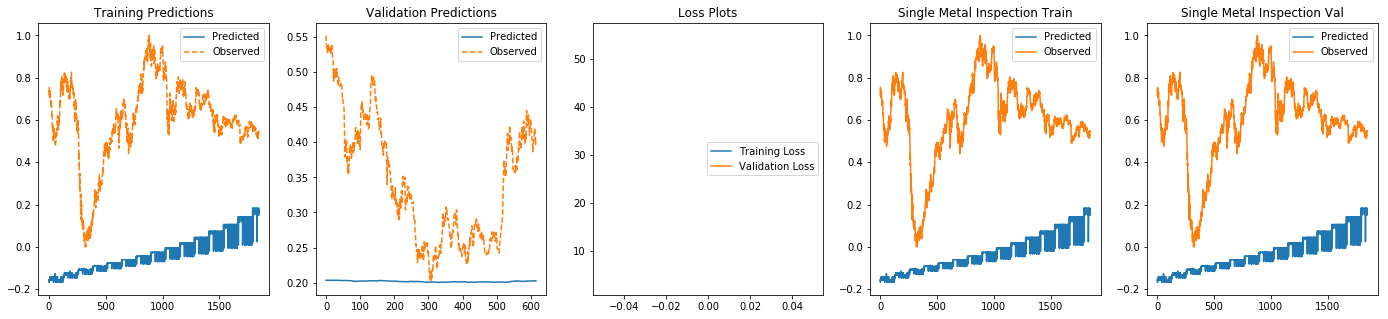

Epoch: 10 Train: 4.26039 Val: 2.81165  Time: 32.833  Best Val: 2.81165


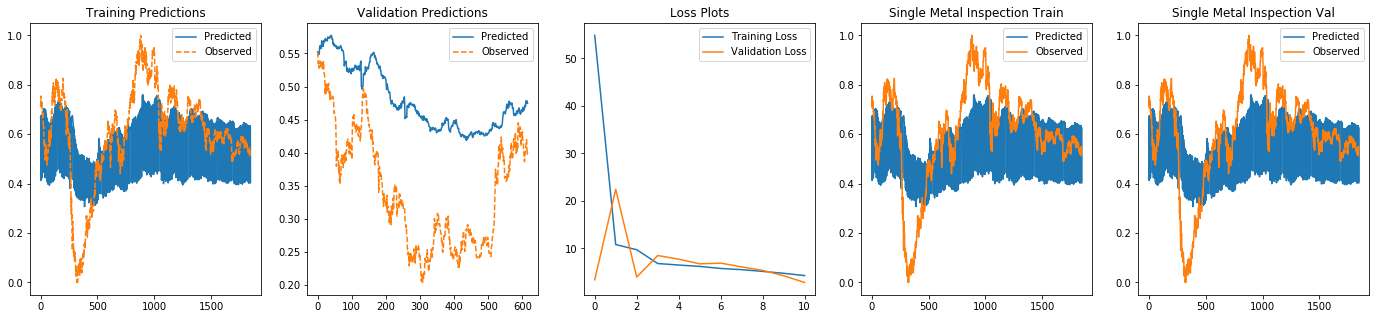

Epoch: 20 Train: 2.08302 Val: 0.53879  Time: 64.248  Best Val: 0.53879


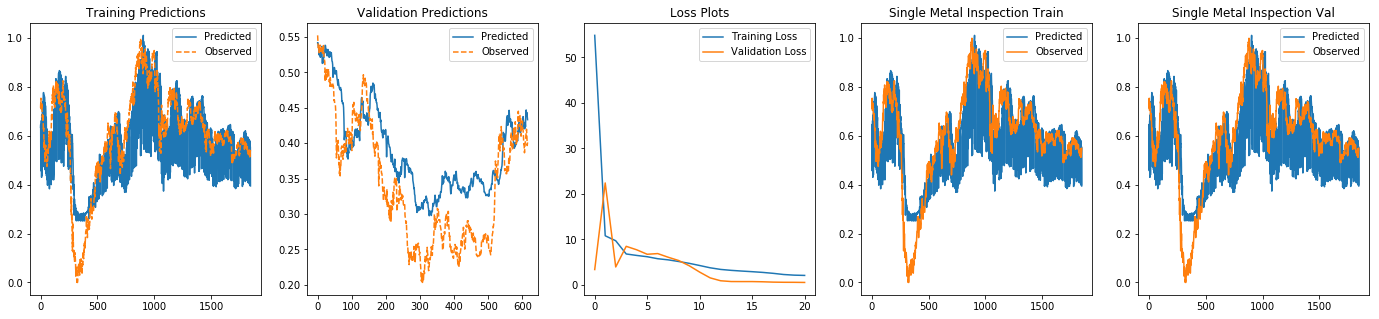

Epoch: 30 Train: 1.91252 Val: 0.52229  Time: 96.024  Best Val: 0.50302


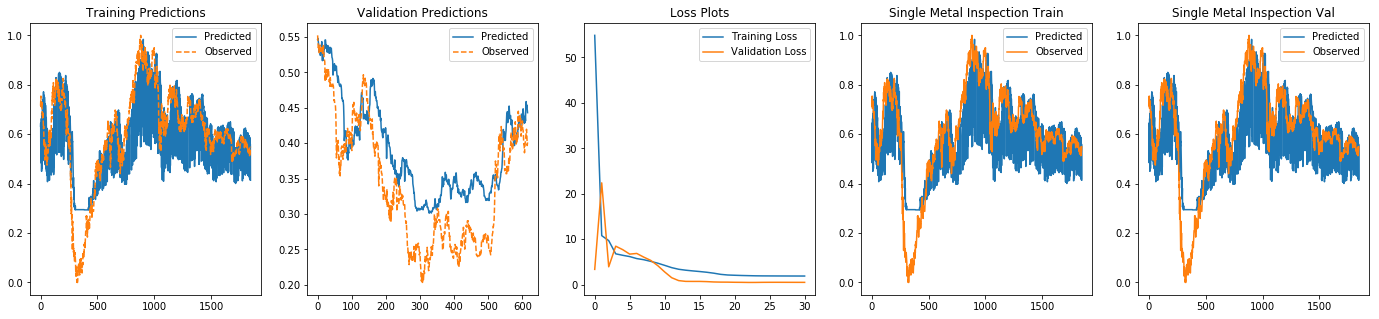

Epoch: 40 Train: 1.89990 Val: 0.48238  Time: 127.128  Best Val: 0.48238


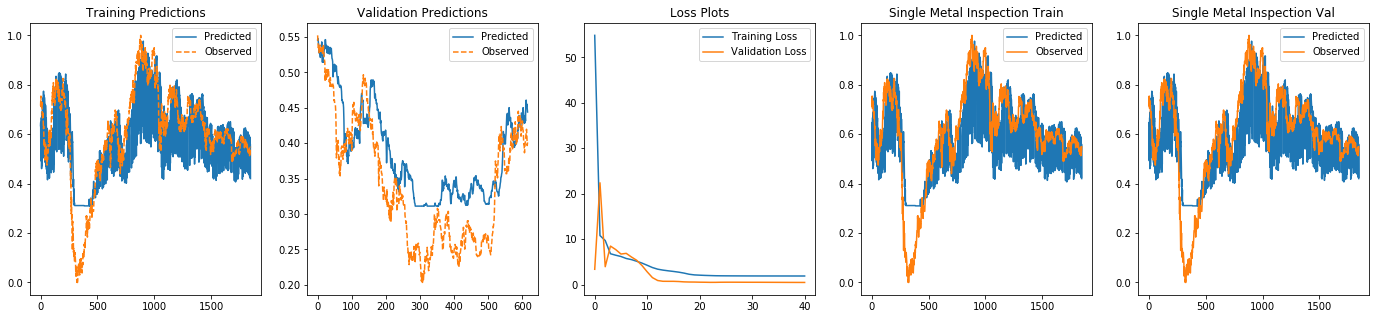

Epoch: 50 Train: 1.89397 Val: 0.45062  Time: 155.597  Best Val: 0.45062


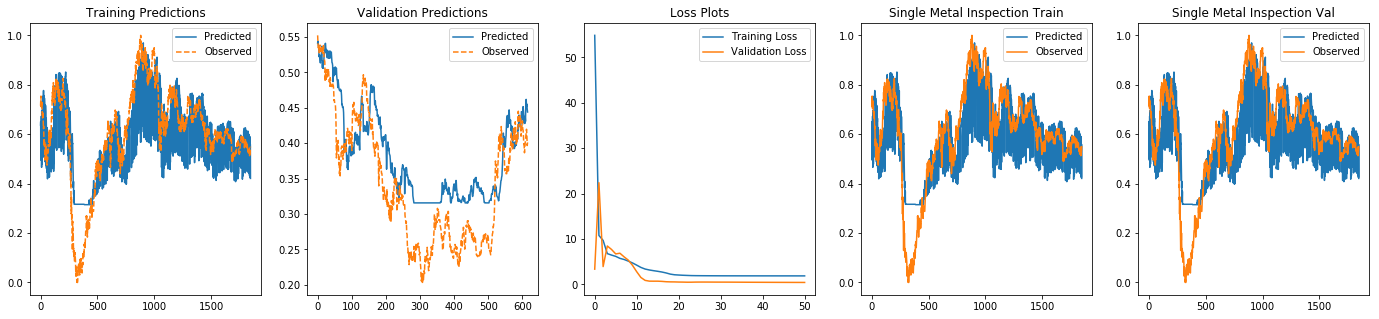

Epoch: 60 Train: 1.87122 Val: 0.39678  Time: 183.268  Best Val: 0.39678


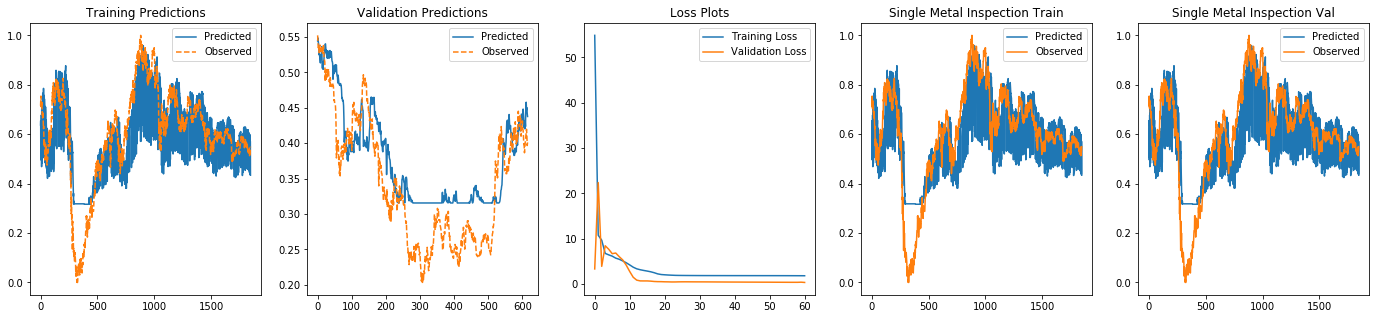

Epoch: 70 Train: 1.69506 Val: 0.57392  Time: 216.131  Best Val: 0.39678


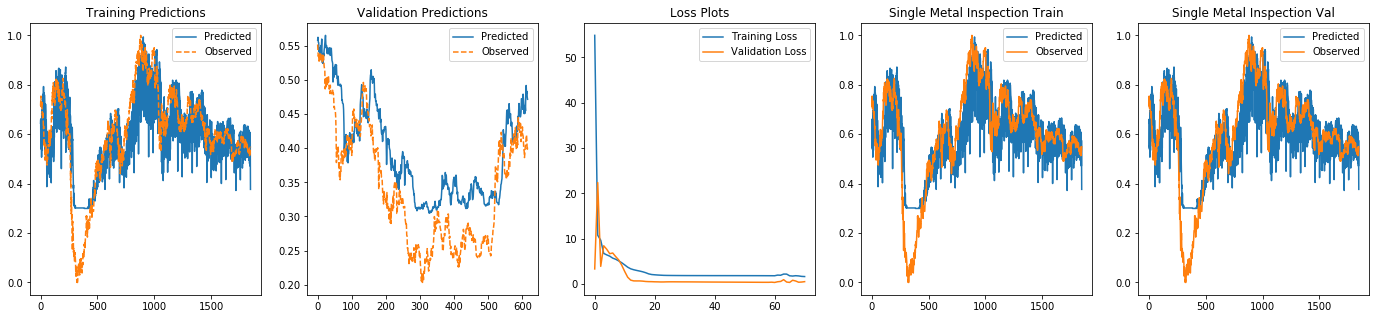

Epoch: 80 Train: 1.67482 Val: 0.42669  Time: 247.080  Best Val: 0.39678


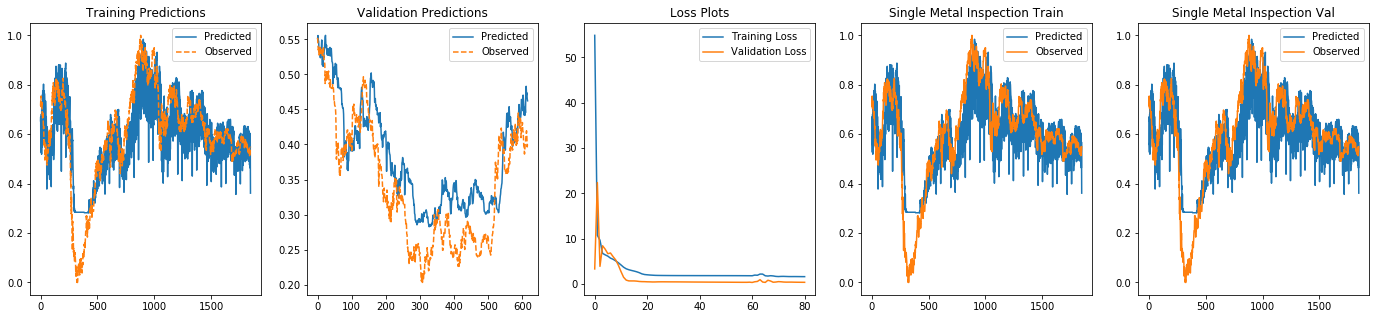

Epoch: 90 Train: 1.85866 Val: 0.56389  Time: 280.185  Best Val: 0.24839


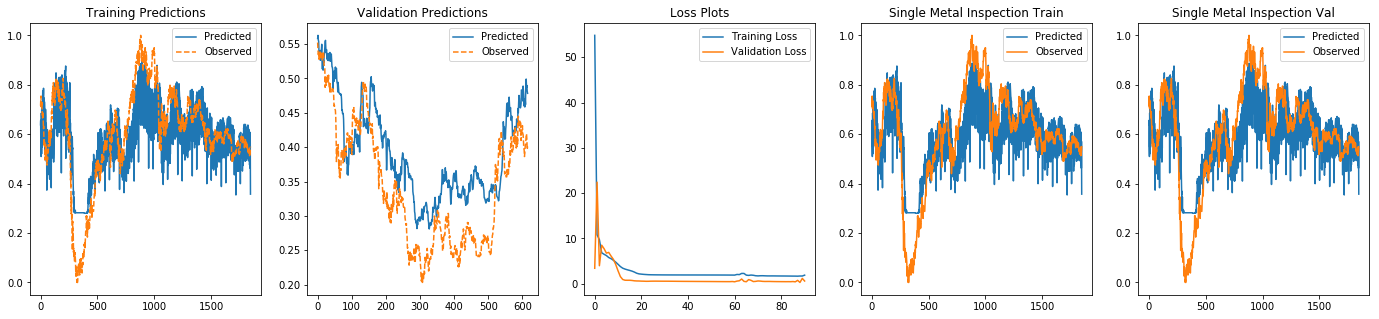

Epoch: 100 Train: 1.61449 Val: 0.36983  Time: 310.316  Best Val: 0.24839


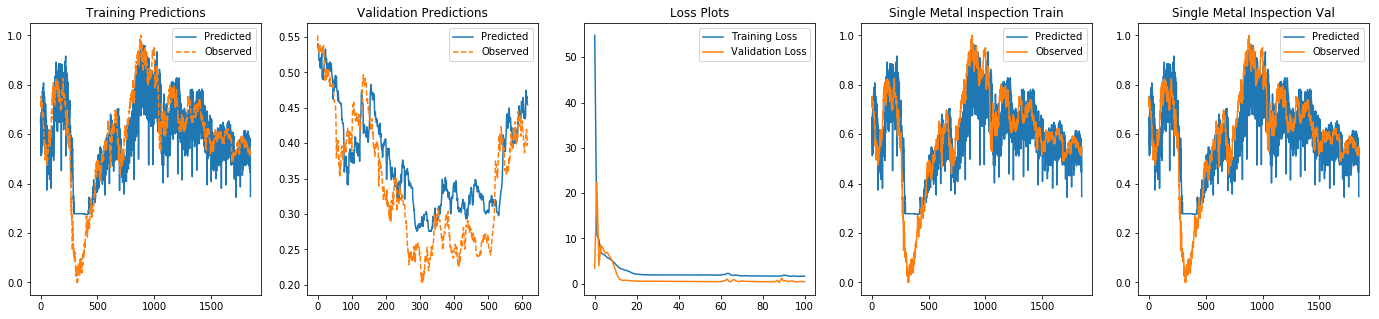

Epoch: 110 Train: 1.59401 Val: 0.24889  Time: 343.996  Best Val: 0.24839


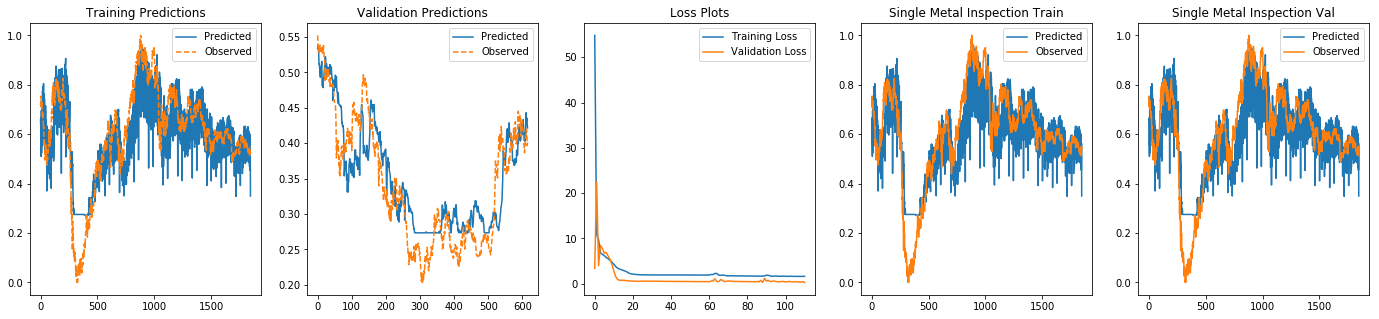

Epoch: 120 Train: 1.42778 Val: 0.68488  Time: 375.121  Best Val: 0.23946


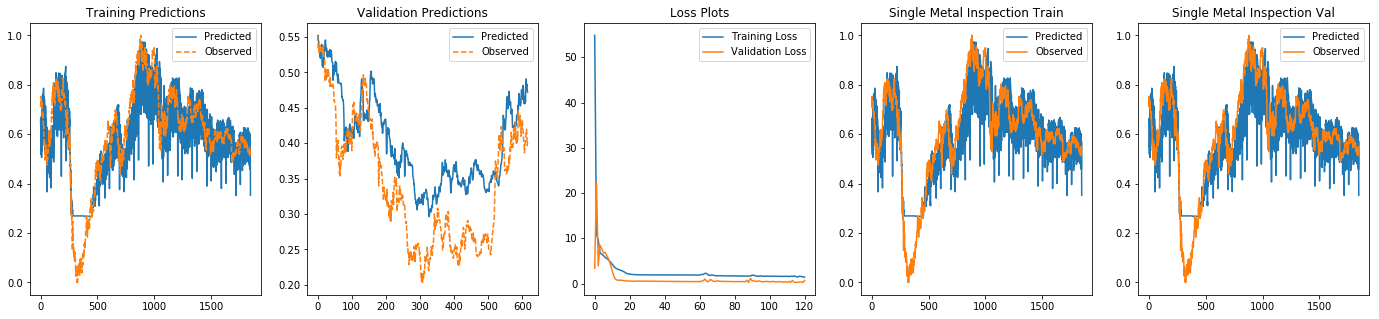

Epoch: 130 Train: 1.44305 Val: 0.37470  Time: 406.659  Best Val: 0.23946


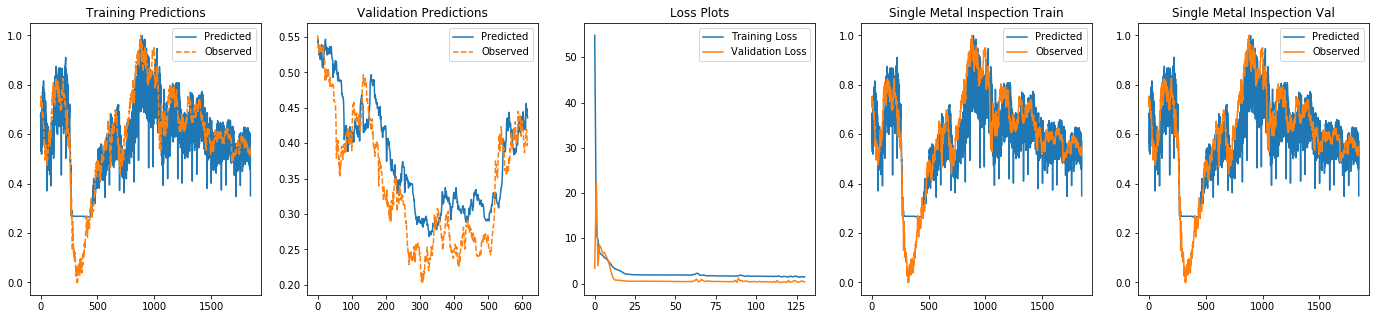

Epoch: 140 Train: 1.97059 Val: 0.44447  Time: 435.811  Best Val: 0.23946


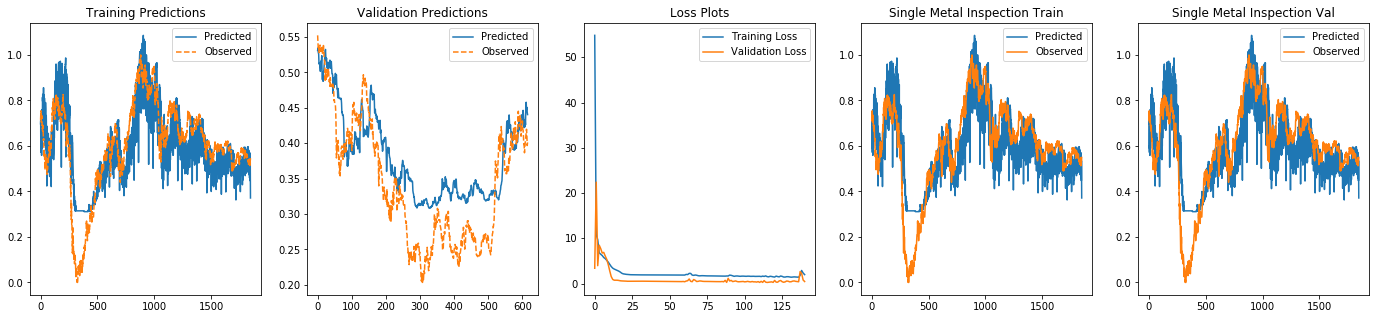

Epoch: 150 Train: 1.62911 Val: 0.43395  Time: 465.872  Best Val: 0.23946


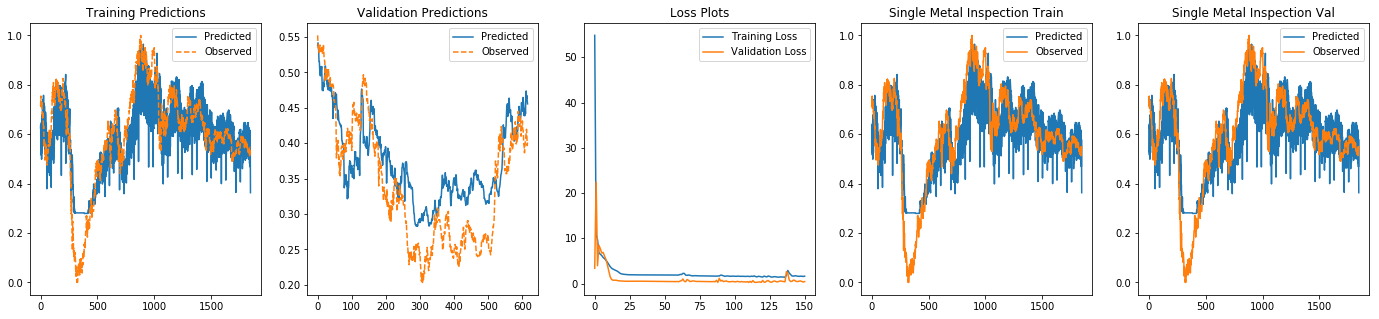

Epoch: 160 Train: 1.46745 Val: 0.34568  Time: 504.017  Best Val: 0.23946


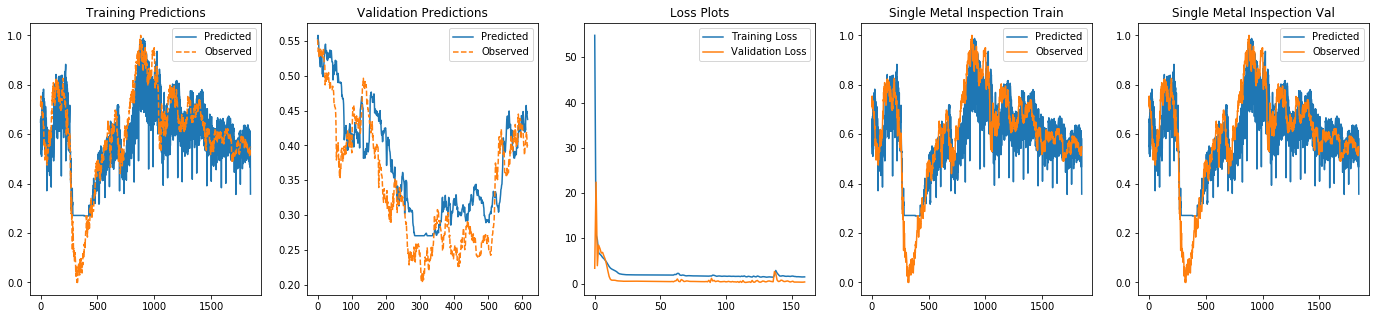

Epoch: 170 Train: 1.74747 Val: 0.64941  Time: 535.000  Best Val: 0.23946


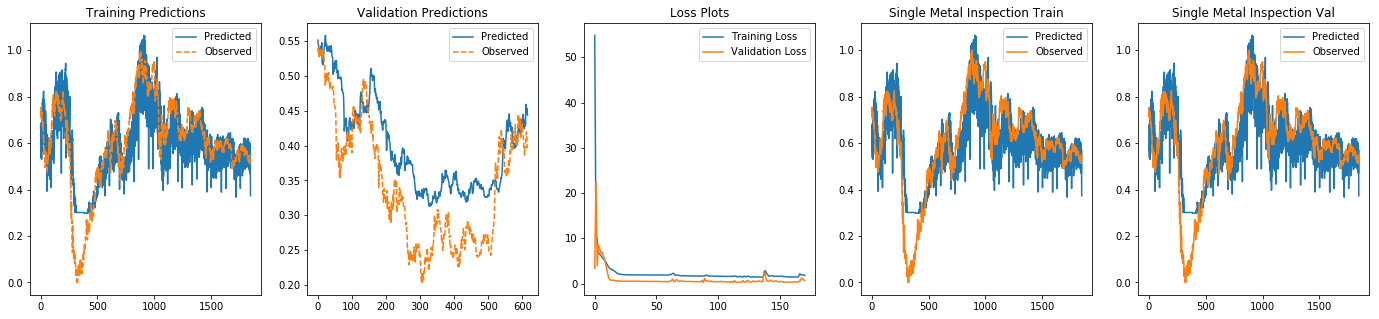

Early Stopping


In [13]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=n_epochs,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=disp_freq,
                        fig_disp_freq=fig_disp_freq, 
                        device=device,
                        patience=patience, 
                        scaler_data_X=scaler_data_X, 
                        scaler_data_y=scaler_data_y)

# Splitting the data into the train, validation and test sets
learning.train_val_test()
learning.training_wrapper()

In [84]:
learning.evaluate(learning.best_model, learning.test_loader)

0.2665704328391695

### Saving Model Object

In [85]:
model_name = "Univariate_SS_H" + str(hidden_dim) + "_F" + str(forecast_length) + "_D" + str(dropout)[2:]
pickle.dump(learning, open("Results/Pickles/" + model_name, 'wb'))
# pickle.dump(learning, open("/content/gdrive/My Drive/Chai/Models/Pickles/" + obj_name, 'wb'))

In [86]:
# learning = pickle.load(open("Results/Pickles/" + "Learning_Univariate_SS_H4_5_", 'rb'))

In [87]:
# model_save(model, 
#            path="/content/gdrive/My Drive/Chai/Models/Pths/",
#            name= "LSTM" + model_name, 
#            val_score=learning.best_val_score)

model_save(model, model_name)

# model = model_load(path="Results/Pths/",
#            model_name="Univariate_SS_H4_5_")

Saving model: Models/Univariate_SS_H8_F22_D1.pth


### Plotting

In [88]:
# Observed
train_true = learning.scaler_data_y.inverse_transform(learning.y_train.numpy())
val_true  = learning.scaler_data_y.inverse_transform(learning.y_val.numpy())
test_true  = learning.scaler_data_y.inverse_transform(learning.y_test.numpy())

# Predicted
train_pred = learning.scaler_data_y.inverse_transform(np.array(learning.train_predictions))
val_pred  = learning.scaler_data_y.inverse_transform(np.array(learning.val_predictions))
test_pred = learning.scaler_data_y.inverse_transform(np.array(learning.test_predictions))

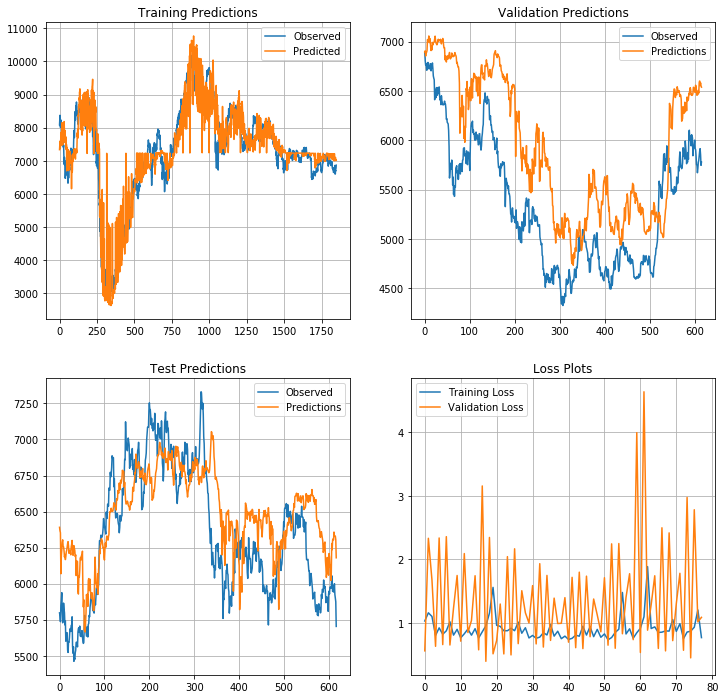

In [89]:
# Rescaling Example
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(train_true, label="Observed")
ax[0, 0].plot(train_pred, label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(val_true, label="Observed")
ax[0, 1].plot(val_pred, label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(test_true, label="Observed")
ax[1, 0].plot(test_pred, label="Predictions")
ax[1, 0].legend()

ax[1, 1].grid()
ax[1, 1].set_title("Loss Plots")
ax[1, 1].plot(learning.logs['Training Loss'], label="Training Loss")
ax[1, 1].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[1, 1].legend()

epoch_reached = str(len(learning.logs['Training Loss']))
path = "Results/Plots/"
val_loss = learning.best_val_score

plt.savefig(path + model_name + ".png")

plt.show()

# Results

In [90]:
# test_increase = 1e-5 * np.array(range(lg_test_pred.shape[0]))
# test_zeros = np.zeros(lg_test_pred.shape)
test_naive = test_true[forecast_length:]

# test_naive = shift(test_true.ravel(), forecast_length)[forecast_length:]

In [91]:
# lg_test_pred.shape, lg_test_true.shape

In [92]:
mse, mae, mde = evaluate(test_pred, test_true, log_ret=False)
print("Price Metrics: ", 
      mse, mae, mde)

Price Metrics:  116875.6442825662 277.0050580439489 0.49188311688311687


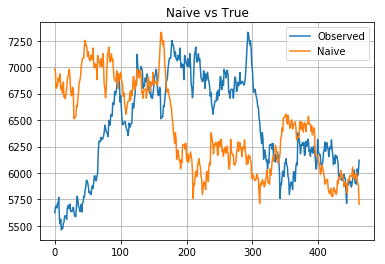

In [479]:
plt.plot(test_true[:-forecast_length] ,label="Observed")
plt.plot(test_naive,label="Naive")
plt.title("Naive vs True")
plt.grid()
plt.legend()
plt.savefig("Results/Plots/" + "Naive_F" + str(forecast_length))
plt.show()

In [93]:
mse_naive, mae_naive, mde_naive = evaluate(test_naive, test_true[:-forecast_length], log_ret=False)
print("naive",
    mse_naive, mae_naive, mde_naive)

naive 90972.555 233.97731 0.4377104377104377
